# Projet: Détection d'erreurs sur des panneaux photovoltaiques à l'aide de reconnaissance d'image.

## Imports, importation des fichiers et création de l'arborescence de fichiers

In [1]:
from __future__ import division, print_function, absolute_import
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import io
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import randint
import xml.etree.ElementTree as ET
from tqdm import tqdm
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, GridSearchCV
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier


import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, save_img, img_to_array, array_to_img
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.activations import relu
from tensorflow.keras.optimizers import SGD,Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

from PIL import Image
from absl import flags
from collections import namedtuple, OrderedDict

### Installation de la librairie Tensorflow Object Detection API

Nécessaire seulement pour la partie 4

In [ ]:
# Clonage du repo git
%%capture
!git clone --depth 1 https://github.com/tensorflow/models

In [ ]:
# Installation
%%capture
%%bash
sudo apt install -y protobuf-compiler
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .
cd ../..

In [ ]:
# Importation des modules utilisés
from object_detection import model_lib_v2
from object_detection.builders import model_builder
from object_detection.utils import label_map_util, config_util, visualization_utils
from object_detection.utils.dataset_util import int64_feature, bytes_feature, float_list_feature, bytes_list_feature, int64_list_feature

### Importation des fichiers

In [2]:
# Connection à google drive pour la gestion des fichiers
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/Colab\ Notebooks/ProjetPV

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/ProjetPV


In [ ]:
# Creation de l'arborescence de fichiers
!mkdir data
!mkdir trained_models
!mkdir data/Tests

mkdir: cannot create directory ‘data’: File exists
mkdir: cannot create directory ‘trained_models’: File exists
mkdir: cannot create directory ‘data/Tests’: File exists


In [ ]:
#Décompression des fichiers
!unzip Original_data.zip -d ./data
!unzip Labeled.zip -d ./data
!unzip Labeled_count.zip -d ./data
!unzip pre-trained-models.zip
!unzip trained-models.zip

Archive:  Original_data.zip
replace ./data/Original_data/Hot Spots line/DJI_0122.JPG? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
Archive:  Labeled.zip
replace ./data/Labeled/DJI_0004.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
Archive:  Labeled_count.zip
replace ./data/Labeled_count/DJI_0004.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
Archive:  pre-trained-models.zip
replace pre-trained-models/faster_rcnn_inception_resnet_v2_640x640_coco17_tpu-8/checkpoint/checkpoint? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [3]:
# Creation de variables de configuration
INPUT_1 = "./data/Original_data"
INPUT_2 = "./data/Labeled_count"
INPUT_3 = "./data/Labeled"
DATA_DIR = "./data"
MULTICLASS = True
FRACTION = 0.8
height = 450
width = 450

## Extraction et visualisation de la donnée

In [4]:
data=[]
classes=[]
classes_bin = []
images_vis=[]

folders = os.listdir(INPUT_1)
for i, folder in enumerate(folders):
    #On liste les fichiers à exploiter
    filepaths = [f"{INPUT_1}/{folder}/{f}" for f in os.listdir(f"{INPUT_1}/{folder}")]
    
    #On ajoute la première image à la liste de visualisation
    images_vis.append(load_img(filepaths[0]))

    #On extrait les images et on les transforme en array
    data.extend([img_to_array(load_img(f,target_size=(height,width))) for f in filepaths])
    classes.extend([i for f in os.listdir(f"{INPUT_1}/{folder}")])
    classes_bin.extend([0 if folder == "Normal PV" else 1 for f in os.listdir(f"{INPUT_1}/{folder}")])
data=np.array(data)
classes=np.array(classes)

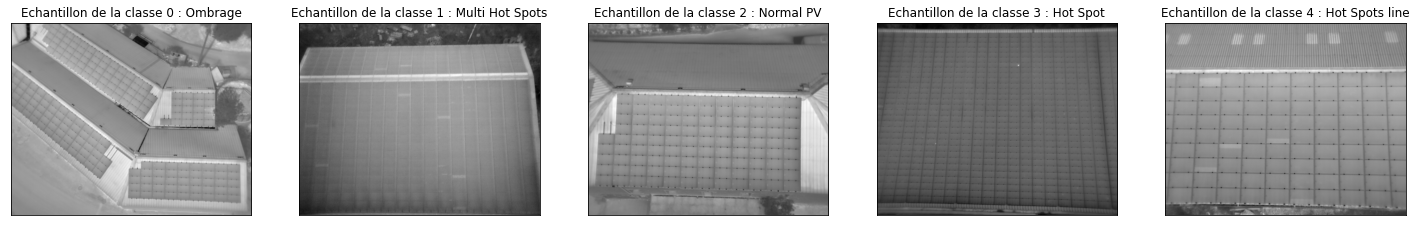

In [5]:
# On visualise rapidement une image de chaque classe
fig = plt.figure(figsize=(25, 25))
for i, im in enumerate(images_vis):
    fig.add_subplot(1, 5, i+1)
    plt.imshow(im)
    plt.xticks(())
    plt.yticks(())
    plt.title(f"Echantillon de la classe {i} : {folders[i]}")

## Tentative de clustering à partir de features extraites par VGG16

In [6]:
# On récupère une architecture VGG16 préentrainée dont on ôte les premières couches
model = VGG16(weights='imagenet', include_top=False)
model.summary()

58892288/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
______________________________________________________________

In [7]:
#On formate chacune des images et on prédit leurs features avec le modèle
predicted_features = []

for img in data:
    img = np.expand_dims(preprocess_input(img), axis=0)
    feature = np.array(model.predict(img))
    predicted_features.append(feature.flatten())

predicted_features = np.array(predicted_features)

In [8]:
#On applique ensuite un clustering Kmeans aux features. Notre objectif est de réussir à séparer en deux clusters les panneaux présentant des défauts et les autres.

kmeans = KMeans(n_clusters=2, random_state=0).fit(predicted_features)
ykmeans = kmeans.predict(predicted_features)

Cluster 1 de longueur : 296 avec 0.7398648648648649% d'images comportant des défauts
Cluster 1 de longueur : 118 avec 0.4322033898305085% d'images comportant des défauts


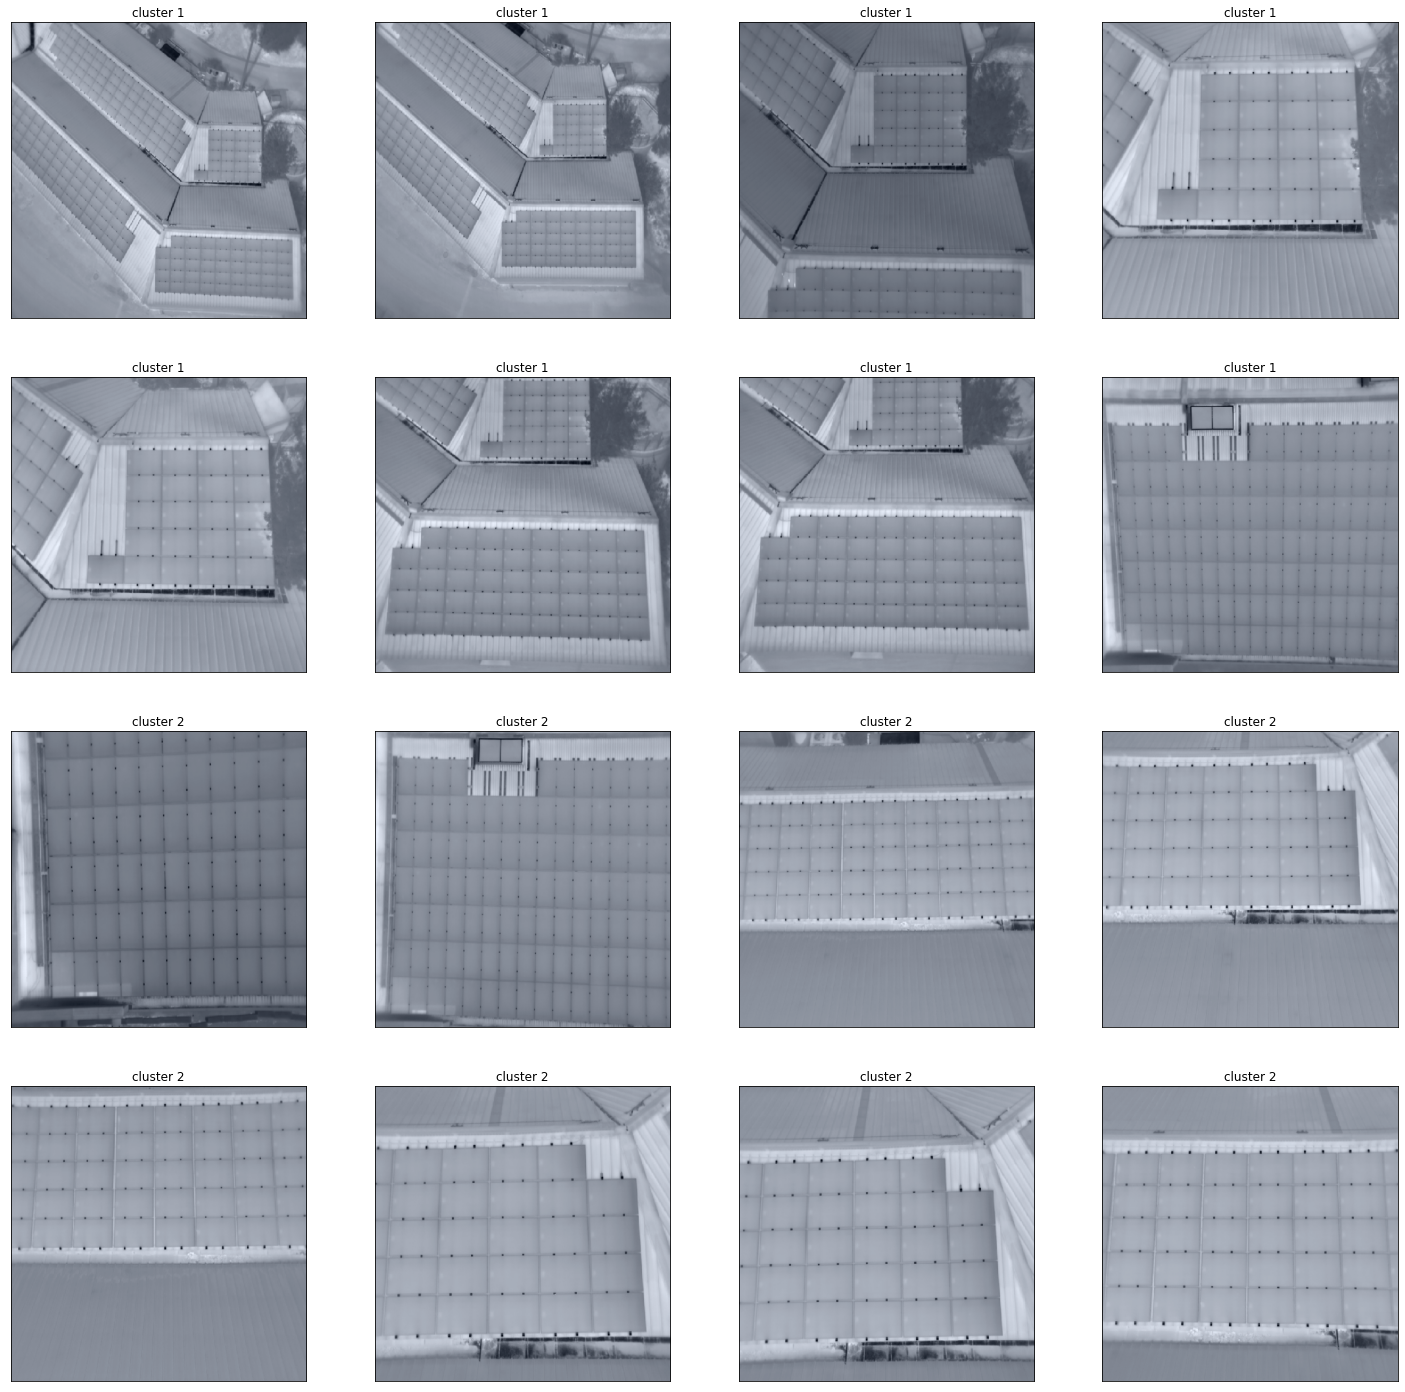

In [9]:
# On visualise les résultats et on analyse les classes du cluster
cluster1 = []
cluster2 = []
classes_cluster_1 = []
classes_cluster_2 = []

for index, (cluster, img) in enumerate(zip(ykmeans, data)):
    if cluster == 0:
        cluster1.append(img)
        classes_cluster_1.append(classes_bin[index])
    elif cluster == 1:
        cluster2.append(img)
        classes_cluster_2.append(classes_bin[index])

n_col = 4
n_row = 4
fig = plt.figure(figsize=(25, 25))

for i in range(int(n_row * n_col / 2)):
    fig.add_subplot(n_row, n_col, i + 1)
    img = array_to_img(cluster1[:8][i])
    plt.imshow(img)
    plt.title('cluster 1')
    plt.xticks(())
    plt.yticks(())
    
for i in range(int(n_row * n_col / 2)):
    fig.add_subplot(n_row, n_col, int(n_row * n_col / 2) + i + 1)
    img = array_to_img(cluster2[:8][i])
    plt.imshow(img)
    plt.title('cluster 2')
    plt.xticks(())
    plt.yticks(())

#On analyse les résultats
print(f"Cluster 1 de longueur : {len(cluster1)} avec {sum(classes_cluster_1)/len(cluster1)}% d'images comportant des défauts")
print(f"Cluster 1 de longueur : {len(cluster2)} avec {sum(classes_cluster_2)/len(cluster2)}% d'images comportant des défauts")

On observe sans trop de surprise des résultats peu concluants. A l'examination de la base de données, il s'avère que les conditions de prise de photo sont très disparates et incluent des différences beaucoup plus fortes que les défauts en eux mêmes. De plus, les données de panneaux photovolotaiques "normaux" comportent aussi certains défauts.

Nous allons maintenant tenter une classification par random forest sur la base des features extraites. Cette approche a l'avantage d'être supervisée et plus précise.

In [10]:
# On sépare dans un premier temps un jeu de train et un jeu de test pour le classifieur.
x_train, x_test, y_train, y_test = train_test_split(predicted_features, classes_bin, test_size=None, train_size=FRACTION)

In [11]:
# On entraine une première forêt aléatoire non optimisée
rf = RandomForestClassifier()
rf.fit(x_train, y_train)
print(f"Score en train : {rf.score(x_train, y_train)} \nScore en test : {rf.score(x_test, y_test)}")

Score en train : 0.9939577039274925 
Score en test : 0.8433734939759037


On obtient des résultats satisfaisants. Utilisons maintenant une cross validation avec recherche aléatoire sur différents paramètres pour optimiser notre algorithme.

In [12]:
# On crée le dictionnaire des paramètres de notre recherche. On fait varier le nombre d'arbres, le nombre de variables à considérer à chaque split,
# la profondeur, et le nombre minimal d'échantillons par feuille et par split.
# Ces choix sont assez empiriques.
grid = {'n_estimators': randint(10, 200),
               'max_depth': randint(5, 50),
               'min_samples_split': randint(2, 15),
               'min_samples_leaf': randint(1, 10)}

In [13]:
rf = RandomForestClassifier()
# Recherche aléatoire avec cross validation a 5 folds en faisant usage de tous les coeurs disponibles
search = RandomizedSearchCV(rf, grid, n_iter = 50, cv = 5, verbose=3, random_state=42, n_jobs = -1)
# On entraine la configuration optimale
search.fit(x_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  2.5min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [ ]:
print(f"Score en train : {search.score(x_train, y_train)} \nScore en test : {search.score(x_test, y_test)}")

Score en train : 0.9003021148036254 
Score en test : 0.9156626506024096


On observe une légère amélioration, mais le nombre de tirages assez restreint que nous appliquons à la recherche aléatoire rend ce résultat peu constant.

On cherche désormais à appliquer la même technique sur l'intégralité des classes.

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(predicted_features, classes, test_size=None, train_size=FRACTION)
rf = RandomForestClassifier()
# Recherche aléatoire avec cross validation a 5 folds en faisant usage de tous les coeurs disponibles
search = RandomizedSearchCV(rf, grid, n_iter = 50, cv = 5, verbose=3, random_state=42, n_jobs = -1)
# On entraine la configuration optimale
search.fit(x_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:  8.3min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed: 17.4min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [ ]:
print(f"Score en train : {search.score(x_train, y_train)} \nScore en test : {search.score(x_test, y_test)}")

Score en train : 0.743202416918429 
Score en test : 0.40963855421686746


## Comptage du nombre de défauts sur des images

### Préprocessing

In [14]:
X = []
y = []
height = 0
width = 0

for f in tqdm(glob.glob(INPUT_2+'/*.xml')):
  root = ET.parse(f).getroot()
  default_number = len(root.findall('object'))
  height = int(root.find('size')[0].text)
  width = int(root.find('size')[1].text)
  name = root.find('filename').text
  image = Image.open(f"{INPUT_2}/{name}").convert('L') # Nous traitons des images thermiques, autant les transformer en grayscale pour économiser du calcul
  X.append(np.array(image))
  y.append(default_number)

X = np.array(X)
y = np.array(y)
X = X.reshape(len(X), height, width, 1)

x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=None, train_size=FRACTION)

100%|██████████| 112/112 [01:24<00:00,  1.33it/s]


In [15]:
# On crée un ImageDataGenerator qui fait de l'augmentation d'image à la volée afin de facililter la généralisation de notre modèle et éviter l'overfitting.

train_datagenerator = ImageDataGenerator(
        rescale=1./255,
        rotation_range=10,
        brightness_range=(0.4,0.7),
        horizontal_flip=True,
        vertical_flip=True)

val_datagenerator= ImageDataGenerator(rescale=1./255)

train_datagenerator.fit(x_train)
val_datagenerator.fit(x_val)

### Construction du modèle

In [16]:
model = tf.keras.Sequential()
model.add(Conv2D(filters=16, kernel_size=(4,4), input_shape=(height, width, 1), activation=relu))
model.add(MaxPooling2D(pool_size=(4, 4)))
model.add(Conv2D(filters=32, kernel_size=(4,4), activation=relu))
model.add(MaxPooling2D(pool_size=(4, 4)))
model.add(Conv2D(filters=32, kernel_size=(4,4), activation=relu))
model.add(MaxPooling2D(pool_size=(4, 4)))
model.add(Flatten())
model.add(Dense(512, activation=relu))
model.add(Dropout(0.2))
model.add(Dense(128, activation=relu))
model.add(Dropout(0.2))
model.add(Dense(64, activation=relu))
model.add(Dropout(0.2))
model.add(Dense(8, activation=relu))
model.add(Dense(1, activation="linear"))
model.compile(loss='mean_squared_error', metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')], optimizer='adam')

### Entrainement

In [18]:
# On définit un early stopping sur la rmse du jeu de validation
callback = tf.keras.callbacks.EarlyStopping(monitor='val_rmse', mode='min', patience=100)
batch_size=16
history = model.fit_generator(train_datagenerator.flow(x_train, y_train, batch_size=batch_size),
                    steps_per_epoch=len(x_train) / batch_size,
                    epochs=1000,
                    validation_data=val_datagenerator.flow(x_val, y_val, batch_size=batch_size),
                    validation_steps=len(x_val) / batch_size,
                    callbacks=[callback], shuffle=True)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/1000
5/5 [==============================] - 4s 481ms/step - loss: 25.9428 - rmse: 5.0875 - val_loss: 81.9279 - val_rmse: 9.0514
Epoch 2/1000
5/5 [==============================] - 2s 441ms/step - loss: 18.4665 - rmse: 4.2847 - val_loss: 19.9892 - val_rmse: 4.4709
Epoch 3/1000
5/5 [==============================] - 3s 488ms/step - loss: 15.3188 - rmse: 3.9119 - val_loss: 41.0488 - val_rmse: 6.4069
Epoch 4/1000
5/5 [==============================] - 3s 451ms/step - loss: 13.7849 - rmse: 3.7116 - val_loss: 25.3060 - val_rmse: 5.0305
Epoch 5/1000
5/5 [==============================] - 3s 457ms/step - loss: 12.0776 - rmse: 3.4659 - val_loss: 22.3818 - val_rmse: 4.7309
Epoch 6/1000
5/5 [==============================] - 3s 501ms/step - loss: 11.2040 - rmse: 3.3360 - val_loss: 35.4638 - val_rmse: 5.9551
Epoch 7/1000
5/5 [==============================] - 3s 489ms/step - loss: 11.2345 - rmse: 3.3440 - val_loss: 25.0799 - val_rmse: 5.0080
Epoch 8/1000
5/5 [==============================

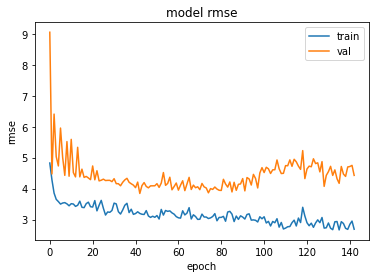

In [19]:
plt.plot(history.history['rmse'])
plt.plot(history.history['val_rmse'])
plt.title('model rmse')
plt.ylabel('rmse')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

## Détection de défauts sur panneaux solaires à l'aide de Tensorflow Object Detection API


### Préprocessing

In [ ]:
def create_csv_from_xml(labels_folder, output, multiclass=False):
   # Lis les fichiers xml des annotations et crée un csv les associant aux fichiers correspondants.
   # Multiclass contrôle l'activation du mode multiclasse dans lequel plusieurs types de défauts sont différenciés. Autrement, le seul label est "défaut".

   info = []
   for f in tqdm(glob.glob(labels_folder+'/*.xml')):
    root = ET.parse(f).getroot()
    for element in root.findall('object'):
      label = element[0].text if multiclass else 'fault'
      info.append((root.find('filename').text,
                int(root.find('size')[0].text),
                int(root.find('size')[1].text),
                label,
                int(element[4][0].text),
                int(element[4][1].text),
                int(element[4][2].text),
                int(element[4][3].text)))
   pd.DataFrame(info, columns=['filename', 'width', 'height', 'label', 'xmin', 'ymin', 'xmax', 'ymax']).to_csv(output, index=None)


def split_train_test(input_csv, fraction):
   df = pd.read_csv(input_csv)
   train_df, test_df = train_test_split(df, test_size=None, train_size=fraction, stratify=df['label'])

   train_df.to_csv(os.path.splitext(input_csv)[0]+'_train.csv', index=False)
   test_df.to_csv(os.path.splitext(input_csv)[0]+'_test.csv', index=False)

def create_pbtxt_and_labels_dict(csv_path, pbtxt_path):
   label_list = list(pd.read_csv(csv_path)['label'].unique())
   label_list.sort()
   content = ''
   label_dict = {}
   for i, l in enumerate(label_list):
     label_dict[l] = i+1
     content += 'item {\n    id: ' + str(i + 1) + '\n    display_name: "' + str(l) + '"\n}\n\n'

   with open(pbtxt_path, "w+") as f:
      f.write(content)
       
   return label_dict


def split(df, group):
   data = namedtuple('data', ['filename', 'object'])
   gb = df.groupby(group)
   return [data(filename, gb.get_group(x)) for filename, x in zip(gb.groups.keys(), gb.groups)]

# Inspiré de https://tensorflow-object-detection-api-tutorial.readthedocs.io/en/latest/training.html#create-tensorflow-records

def create_tf_example(group, path, label_dict):
   with tf.io.gfile.GFile(os.path.join(path, '{}'.format(group.filename)), 'rb') as fid:
      encoded_jpg = fid.read()
   encoded_jpg_io = io.BytesIO(encoded_jpg)
   image = Image.open(encoded_jpg_io)
   width, height = image.size

   filename = group.filename.encode('utf8')
   xmins = []
   xmaxs = []
   ymins = []
   ymaxs = []
   labels_text = []
   labels = []

   for index, row in group.object.iterrows():
      if set(['xmin_rel', 'xmax_rel', 'ymin_rel', 'ymax_rel']).issubset(set(row.index)):
         xmin = row['xmin_rel']
         xmax = row['xmax_rel']
         ymin = row['ymin_rel']
         ymax = row['ymax_rel']

      elif set(['xmin', 'xmax', 'ymin', 'ymax']).issubset(set(row.index)):
         xmin = row['xmin'] / width
         xmax = row['xmax'] / width
         ymin = row['ymin'] / height
         ymax = row['ymax'] / height

      xmins.append(xmin)
      xmaxs.append(xmax)
      ymins.append(ymin)
      ymaxs.append(ymax)
      labels_text.append(str(row['label']).encode('utf8'))
      labels.append(label_dict[str(row['label'])])

   tf_example = tf.train.Example(features=tf.train.Features(
       feature={
           'image/height': int64_feature(height),
           'image/width': int64_feature(width),
           'image/filename': bytes_feature(filename),
           'image/source_id': bytes_feature(filename),
           'image/encoded': bytes_feature(encoded_jpg),
           'image/format': bytes_feature('jpg'.encode('utf8')),
           'image/object/bbox/xmin': float_list_feature(xmins),
           'image/object/bbox/xmax': float_list_feature(xmaxs),
           'image/object/bbox/ymin': float_list_feature(ymins),
           'image/object/bbox/ymax': float_list_feature(ymaxs),
           'image/object/class/text': bytes_list_feature(labels_text),
           'image/object/class/label': int64_list_feature(labels),
         }))
   return tf_example


def create_TFRecord(csv_input, pbtxt_path, image_dir, output_path):
   label_dict = create_pbtxt_and_labels_dict(csv_input, pbtxt_path)
   writer = tf.compat.v1.python_io.TFRecordWriter(output_path)
   path = os.path.join(image_dir)
   examples = pd.read_csv(csv_input)
   grouped = split(examples, 'filename')

   for group in tqdm(grouped, desc='groups'):
      tf_example = create_tf_example(group, path, label_dict)
      writer.write(tf_example.SerializeToString())

   writer.close()
   output_path = os.path.join(os.getcwd(), output_path)

In [ ]:
base_dir = DATA_DIR + "/class_labels_multi" if MULTICLASS else DATA_DIR + "/class_labels"
output_csv_path = base_dir+".csv"
train_csv_path = base_dir+"_train.csv"
test_csv_path = base_dir+"_test.csv"
labels_path = DATA_DIR+"/label_map.pbtxt"
tf_train_path = DATA_DIR+"/multiclass_train.tfrecord" if MULTICLASS else DATA_DIR+"/train.tfrecord"
tf_test_path = DATA_DIR+"/multiclass_test.tfrecord" if MULTICLASS else DATA_DIR+"/test.tfrecord"

create_csv_from_xml(INPUT_3, output_csv_path, MULTICLASS)
split_train_test(output_csv_path, FRACTION)

create_TFRecord(train_csv_path, labels_path, INPUT_3, tf_train_path)
create_TFRecord(test_csv_path, labels_path, INPUT_3, tf_test_path)


groups: 100%|██████████| 72/72 [00:01<00:00, 44.02it/s]


### Entrainement du modèle

In [20]:
#@title Model Selection { display-mode: "form", run: "auto" }
MODELS = {
'SSD MobileNet v2 320x320' : 'ssd_mobilenet_v2_320x320_coco17_tpu-8',
'SSD MobileNet V1 FPN 640x640' : 'ssd_mobilenet_v1_fpn_640x640_coco17_tpu-8',
'SSD ResNet50 V1 FPN 640x640 (RetinaNet50)' : 'ssd_resnet50_v1_fpn_640x640_coco17_tpu-8',
'Faster R-CNN Inception ResNet V2 640x640' : 'faster_rcnn_inception_resnet_v2_640x640_coco17_tpu-8'
}
model_display = 'SSD MobileNet V1 FPN 640x640' # @param ['SSD MobileNet v2 320x320','SSD MobileNet V1 FPN 640x640','SSD ResNet50 V1 FPN 640x640 (RetinaNet50)', 'Faster R-CNN Inception ResNet V2 640x640']
model_selected = MODELS[model_display]
pipeline_file_name = "pipeline_multi.config" if MULTICLASS else "pipeline.config"

In [21]:
# On prépare les flags nécessaires à la bonne exécution de l'application tensorflow
flags.DEFINE_string('pipeline_config_path', f"./pre-trained-models/{model_selected}/{pipeline_file_name}", 'Chemin vers le fichier de configuration du pipeline '
                    'file.')
flags.DEFINE_string('model_dir', f"./trained_models/{model_selected}", 'Chemin vers le dossier de stockage des modèles entrainés')
flags.DEFINE_string('checkpoint_dir', None, 'Chemin vers le répertoire des checkpoints. Si précisé, le modèle fonctionne en mode evaluation et enregistre les métriques dans le dossier modèle')

flags.DEFINE_integer('eval_timeout', 3600, 'Nombre de seconde d attente d un chekpoint d evaluation avant d annuler l execution')
FLAGS = flags.FLAGS

In [ ]:
# On définit la fonction d'éxécution de l'entrainement
def main(unused_argv):
  if FLAGS.checkpoint_dir:
    model_lib_v2.eval_continuously(
        pipeline_config_path=FLAGS.pipeline_config_path,
        model_dir=FLAGS.model_dir,
        train_steps=None,
        sample_1_of_n_eval_examples=None,
        sample_1_of_n_eval_on_train_examples=(5),
        checkpoint_dir=FLAGS.checkpoint_dir,
        wait_interval=300, timeout=3600)
  else:
    strategy = tf.compat.v2.distribute.MirroredStrategy()

    with strategy.scope():
      model_lib_v2.train_loop(
          pipeline_config_path=FLAGS.pipeline_config_path,
          model_dir=FLAGS.model_dir,
          train_steps=None,
          checkpoint_every_n=1000,
          record_summaries=True)

if __name__ == '__main__':
  tf.compat.v1.app.run()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


I0225 14:28:48.871042 139977695057792 mirrored_strategy.py:350] Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


INFO:tensorflow:Maybe overwriting train_steps: None


I0225 14:28:48.887625 139977695057792 config_util.py:552] Maybe overwriting train_steps: None


INFO:tensorflow:Maybe overwriting use_bfloat16: False


I0225 14:28:48.889998 139977695057792 config_util.py:552] Maybe overwriting use_bfloat16: False


INFO:tensorflow:Reading unweighted datasets: ['./data/multiclass_train.tfrecord']


I0225 14:28:51.471853 139977695057792 dataset_builder.py:163] Reading unweighted datasets: ['./data/multiclass_train.tfrecord']


INFO:tensorflow:Reading record datasets for input file: ['./data/multiclass_train.tfrecord']


I0225 14:28:51.479161 139977695057792 dataset_builder.py:80] Reading record datasets for input file: ['./data/multiclass_train.tfrecord']


INFO:tensorflow:Number of filenames to read: 1


I0225 14:28:51.481739 139977695057792 dataset_builder.py:81] Number of filenames to read: 1


W0225 14:28:51.484760 139977695057792 dataset_builder.py:88] num_readers has been reduced to 1 to match input file shards.


Instructions for updating:
Use `tf.data.Dataset.interleave(map_func, cycle_length, block_length, num_parallel_calls=tf.data.AUTOTUNE)` instead. If sloppy execution is desired, use `tf.data.Options.experimental_deterministic`.


W0225 14:28:51.495956 139977695057792 deprecation.py:339] From /usr/local/lib/python3.7/dist-packages/object_detection/builders/dataset_builder.py:105: parallel_interleave (from tensorflow.python.data.experimental.ops.interleave_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.data.Dataset.interleave(map_func, cycle_length, block_length, num_parallel_calls=tf.data.AUTOTUNE)` instead. If sloppy execution is desired, use `tf.data.Options.experimental_deterministic`.


Instructions for updating:
Use `tf.data.Dataset.map()


W0225 14:28:51.529998 139977695057792 deprecation.py:339] From /usr/local/lib/python3.7/dist-packages/object_detection/builders/dataset_builder.py:237: DatasetV1.map_with_legacy_function (from tensorflow.python.data.ops.dataset_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.data.Dataset.map()


Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.


W0225 14:28:57.932869 139977695057792 deprecation.py:339] From /usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:201: sparse_to_dense (from tensorflow.python.ops.sparse_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.


Instructions for updating:
`seed2` arg is deprecated.Use sample_distorted_bounding_box_v2 instead.


W0225 14:29:00.886999 139977695057792 deprecation.py:339] From /usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:201: sample_distorted_bounding_box (from tensorflow.python.ops.image_ops_impl) is deprecated and will be removed in a future version.
Instructions for updating:
`seed2` arg is deprecated.Use sample_distorted_bounding_box_v2 instead.


Instructions for updating:
Use `tf.cast` instead.


W0225 14:29:02.509388 139977695057792 deprecation.py:339] From /usr/local/lib/python3.7/dist-packages/object_detection/inputs.py:282: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:434: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


W0225 14:29:27.604006 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._groundtruth_lists


W0225 14:29:27.605899 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor


W0225 14:29:27.612442 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._batched_prediction_tensor_names


W0225 14:29:27.617366 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._box_prediction_head


W0225 14:29:27.619759 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._prediction_heads


W0225 14:29:27.623279 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._sorted_head_names


W0225 14:29:27.624566 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._additional_projection_layers


W0225 14:29:27.627975 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads


W0225 14:29:27.629762 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._head_scope_conv_layers


W0225 14:29:27.633230 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._box_prediction_head._box_encoder_layers


W0225 14:29:27.638065 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._prediction_heads.class_predictions_with_background


W0225 14:29:27.644344 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._additional_projection_layers.0


W0225 14:29:27.645847 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._additional_projection_layers.1


W0225 14:29:27.647177 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._additional_projection_layers.2


W0225 14:29:27.648631 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._additional_projection_layers.3


W0225 14:29:27.652609 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._additional_projection_layers.4


W0225 14:29:27.654309 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.box_encodings


W0225 14:29:27.655655 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.class_predictions_with_background


W0225 14:29:27.656982 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._head_scope_conv_layers.BoxPredictionTower


W0225 14:29:27.658274 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._head_scope_conv_layers.ClassPredictionTower


W0225 14:29:27.659630 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._box_prediction_head._box_encoder_layers.0


W0225 14:29:27.662269 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._prediction_heads.class_predictions_with_background._class_predictor_layers


W0225 14:29:27.663894 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.box_encodings.0


W0225 14:29:27.666183 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.box_encodings.1


W0225 14:29:27.667548 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.box_encodings.2


W0225 14:29:27.668963 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.box_encodings.3


W0225 14:29:27.670427 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.box_encodings.4


W0225 14:29:27.671777 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.class_predictions_with_background.0


W0225 14:29:27.673093 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.class_predictions_with_background.1


W0225 14:29:27.674520 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.class_predictions_with_background.2


W0225 14:29:27.676029 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.class_predictions_with_background.3


W0225 14:29:27.677355 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.class_predictions_with_background.4


W0225 14:29:27.678684 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._head_scope_conv_layers.BoxPredictionTower.0


W0225 14:29:27.680088 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._head_scope_conv_layers.BoxPredictionTower.1


W0225 14:29:27.681560 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._head_scope_conv_layers.BoxPredictionTower.2


W0225 14:29:27.682928 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._head_scope_conv_layers.BoxPredictionTower.3


W0225 14:29:27.684280 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._head_scope_conv_layers.ClassPredictionTower.0


W0225 14:29:27.685679 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._head_scope_conv_layers.ClassPredictionTower.1


W0225 14:29:27.688370 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._head_scope_conv_layers.ClassPredictionTower.2


W0225 14:29:27.689758 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._head_scope_conv_layers.ClassPredictionTower.3


W0225 14:29:27.691157 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._box_prediction_head._box_encoder_layers.0.kernel


W0225 14:29:27.692645 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._box_prediction_head._box_encoder_layers.0.bias


W0225 14:29:27.694116 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._prediction_heads.class_predictions_with_background._class_predictor_layers.0


W0225 14:29:27.695467 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.box_encodings.0.1


W0225 14:29:27.696792 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.box_encodings.0.2


W0225 14:29:27.698195 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.box_encodings.0.4


W0225 14:29:27.700135 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.box_encodings.0.5


W0225 14:29:27.701535 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.box_encodings.0.7


W0225 14:29:27.702854 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.box_encodings.0.8


W0225 14:29:27.704205 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.box_encodings.0.10


W0225 14:29:27.705764 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.box_encodings.0.11


W0225 14:29:27.707166 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.box_encodings.1.1


W0225 14:29:27.708532 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.box_encodings.1.2


W0225 14:29:27.709857 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.box_encodings.1.4


W0225 14:29:27.711263 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.box_encodings.1.5


W0225 14:29:27.712979 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.box_encodings.1.7


W0225 14:29:27.714297 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.box_encodings.1.8


W0225 14:29:27.715675 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.box_encodings.1.10


W0225 14:29:27.717230 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.box_encodings.1.11


W0225 14:29:27.718732 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.box_encodings.2.1


W0225 14:29:27.720098 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.box_encodings.2.2


W0225 14:29:27.721376 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.box_encodings.2.4


W0225 14:29:27.722726 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.box_encodings.2.5


W0225 14:29:27.724186 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.box_encodings.2.7


W0225 14:29:27.725626 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.box_encodings.2.8


W0225 14:29:27.726988 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.box_encodings.2.10


W0225 14:29:27.728317 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.box_encodings.2.11


W0225 14:29:27.729747 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.box_encodings.3.1


W0225 14:29:27.731217 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.box_encodings.3.2


W0225 14:29:27.732576 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.box_encodings.3.4


W0225 14:29:27.733866 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.box_encodings.3.5


W0225 14:29:27.735261 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.box_encodings.3.7


W0225 14:29:27.736740 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.box_encodings.3.8


W0225 14:29:27.738159 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.box_encodings.3.10


W0225 14:29:27.739532 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.box_encodings.3.11


W0225 14:29:27.740940 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.box_encodings.4.1


W0225 14:29:27.742337 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.box_encodings.4.2


W0225 14:29:27.743732 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.box_encodings.4.4


W0225 14:29:27.745338 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.box_encodings.4.5


W0225 14:29:27.746755 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.box_encodings.4.7


W0225 14:29:27.748100 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.box_encodings.4.8


W0225 14:29:27.749548 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.box_encodings.4.10


W0225 14:29:27.750973 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.box_encodings.4.11


W0225 14:29:27.752389 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.class_predictions_with_background.0.1


W0225 14:29:27.753838 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.class_predictions_with_background.0.2


W0225 14:29:27.755154 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.class_predictions_with_background.0.4


W0225 14:29:27.756530 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.class_predictions_with_background.0.5


W0225 14:29:27.757897 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.class_predictions_with_background.0.7


W0225 14:29:27.759290 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.class_predictions_with_background.0.8


W0225 14:29:27.760807 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.class_predictions_with_background.0.10


W0225 14:29:27.762264 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.class_predictions_with_background.0.11


W0225 14:29:27.763714 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.class_predictions_with_background.1.1


W0225 14:29:27.765161 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.class_predictions_with_background.1.2


W0225 14:29:27.766605 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.class_predictions_with_background.1.4


W0225 14:29:27.767910 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.class_predictions_with_background.1.5


W0225 14:29:27.769135 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.class_predictions_with_background.1.7


W0225 14:29:27.770567 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.class_predictions_with_background.1.8


W0225 14:29:27.771923 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.class_predictions_with_background.1.10


W0225 14:29:27.773201 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.class_predictions_with_background.1.11


W0225 14:29:27.774620 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.class_predictions_with_background.2.1


W0225 14:29:27.775825 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.class_predictions_with_background.2.2


W0225 14:29:27.777107 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.class_predictions_with_background.2.4


W0225 14:29:27.778514 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.class_predictions_with_background.2.5


W0225 14:29:27.779883 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.class_predictions_with_background.2.7


W0225 14:29:27.781215 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.class_predictions_with_background.2.8


W0225 14:29:27.782464 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.class_predictions_with_background.2.10


W0225 14:29:27.783631 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.class_predictions_with_background.2.11


W0225 14:29:27.784712 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.class_predictions_with_background.3.1


W0225 14:29:27.786072 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.class_predictions_with_background.3.2


W0225 14:29:27.787893 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.class_predictions_with_background.3.4


W0225 14:29:27.789466 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.class_predictions_with_background.3.5


W0225 14:29:27.790940 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.class_predictions_with_background.3.7


W0225 14:29:27.792494 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.class_predictions_with_background.3.8


W0225 14:29:27.793833 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.class_predictions_with_background.3.10


W0225 14:29:27.795259 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.class_predictions_with_background.3.11


W0225 14:29:27.796862 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.class_predictions_with_background.4.1


W0225 14:29:27.798352 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.class_predictions_with_background.4.2


W0225 14:29:27.799964 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.class_predictions_with_background.4.4


W0225 14:29:27.801311 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.class_predictions_with_background.4.5


W0225 14:29:27.802874 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.class_predictions_with_background.4.7


W0225 14:29:27.804374 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.class_predictions_with_background.4.8


W0225 14:29:27.805932 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.class_predictions_with_background.4.10


W0225 14:29:27.807420 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.class_predictions_with_background.4.11


W0225 14:29:27.808771 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._head_scope_conv_layers.BoxPredictionTower.0.kernel


W0225 14:29:27.810154 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._head_scope_conv_layers.BoxPredictionTower.1.kernel


W0225 14:29:27.811383 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._head_scope_conv_layers.BoxPredictionTower.2.kernel


W0225 14:29:27.812636 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._head_scope_conv_layers.BoxPredictionTower.3.kernel


W0225 14:29:27.814011 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._head_scope_conv_layers.ClassPredictionTower.0.kernel


W0225 14:29:27.815569 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._head_scope_conv_layers.ClassPredictionTower.1.kernel


W0225 14:29:27.817113 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._head_scope_conv_layers.ClassPredictionTower.2.kernel


W0225 14:29:27.818627 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._head_scope_conv_layers.ClassPredictionTower.3.kernel


W0225 14:29:27.820057 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._prediction_heads.class_predictions_with_background._class_predictor_layers.0.kernel


W0225 14:29:27.821394 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._prediction_heads.class_predictions_with_background._class_predictor_layers.0.bias


W0225 14:29:27.822655 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.box_encodings.0.1.axis


W0225 14:29:27.824721 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.box_encodings.0.1.gamma


W0225 14:29:27.827507 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.box_encodings.0.1.beta


W0225 14:29:27.829053 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.box_encodings.0.1.moving_mean


W0225 14:29:27.830636 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.box_encodings.0.1.moving_variance


W0225 14:29:27.832335 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.box_encodings.0.4.axis


W0225 14:29:27.836864 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.box_encodings.0.4.gamma


W0225 14:29:27.841738 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.box_encodings.0.4.beta


W0225 14:29:27.849822 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.box_encodings.0.4.moving_mean


W0225 14:29:27.854701 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.box_encodings.0.4.moving_variance


W0225 14:29:27.859318 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.box_encodings.0.7.axis


W0225 14:29:27.861002 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.box_encodings.0.7.gamma


W0225 14:29:27.870818 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.box_encodings.0.7.beta


W0225 14:29:27.875745 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.box_encodings.0.7.moving_mean


W0225 14:29:27.884774 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.box_encodings.0.7.moving_variance


W0225 14:29:27.889033 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.box_encodings.0.10.axis


W0225 14:29:27.890739 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.box_encodings.0.10.gamma


W0225 14:29:27.894731 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.box_encodings.0.10.beta


W0225 14:29:27.896445 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.box_encodings.0.10.moving_mean


W0225 14:29:27.900518 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.box_encodings.0.10.moving_variance


W0225 14:29:27.904753 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.box_encodings.1.1.axis


W0225 14:29:27.906456 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.box_encodings.1.1.gamma


W0225 14:29:27.910537 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.box_encodings.1.1.beta


W0225 14:29:27.912167 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.box_encodings.1.1.moving_mean


W0225 14:29:27.916352 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.box_encodings.1.1.moving_variance


W0225 14:29:27.920489 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.box_encodings.1.4.axis


W0225 14:29:27.922063 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.box_encodings.1.4.gamma


W0225 14:29:27.931480 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.box_encodings.1.4.beta


W0225 14:29:27.935731 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.box_encodings.1.4.moving_mean


W0225 14:29:27.940564 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.box_encodings.1.4.moving_variance


W0225 14:29:27.948601 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.box_encodings.1.7.axis


W0225 14:29:27.952827 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.box_encodings.1.7.gamma


W0225 14:29:27.954487 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.box_encodings.1.7.beta


W0225 14:29:27.958900 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.box_encodings.1.7.moving_mean


W0225 14:29:27.962948 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.box_encodings.1.7.moving_variance


W0225 14:29:27.969158 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.box_encodings.1.10.axis


W0225 14:29:27.973580 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.box_encodings.1.10.gamma


W0225 14:29:27.980667 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.box_encodings.1.10.beta


W0225 14:29:27.985162 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.box_encodings.1.10.moving_mean


W0225 14:29:27.990455 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.box_encodings.1.10.moving_variance


W0225 14:29:27.992643 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.box_encodings.2.1.axis


W0225 14:29:27.999663 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.box_encodings.2.1.gamma


W0225 14:29:28.004177 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.box_encodings.2.1.beta


W0225 14:29:28.009465 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.box_encodings.2.1.moving_mean


W0225 14:29:28.014227 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.box_encodings.2.1.moving_variance


W0225 14:29:28.017994 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.box_encodings.2.4.axis


W0225 14:29:28.023620 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.box_encodings.2.4.gamma


W0225 14:29:28.026376 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.box_encodings.2.4.beta


W0225 14:29:28.030173 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.box_encodings.2.4.moving_mean


W0225 14:29:28.034571 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.box_encodings.2.4.moving_variance


W0225 14:29:28.035780 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.box_encodings.2.7.axis


W0225 14:29:28.040688 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.box_encodings.2.7.gamma


W0225 14:29:28.044195 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.box_encodings.2.7.beta


W0225 14:29:28.047507 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.box_encodings.2.7.moving_mean


W0225 14:29:28.050035 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.box_encodings.2.7.moving_variance


W0225 14:29:28.052602 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.box_encodings.2.10.axis


W0225 14:29:28.057013 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.box_encodings.2.10.gamma


W0225 14:29:28.059629 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.box_encodings.2.10.beta


W0225 14:29:28.064558 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.box_encodings.2.10.moving_mean


W0225 14:29:28.088480 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.box_encodings.2.10.moving_variance


W0225 14:29:28.089899 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.box_encodings.3.1.axis


W0225 14:29:28.093863 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.box_encodings.3.1.gamma


W0225 14:29:28.096776 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.box_encodings.3.1.beta


W0225 14:29:28.098065 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.box_encodings.3.1.moving_mean


W0225 14:29:28.099366 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.box_encodings.3.1.moving_variance


W0225 14:29:28.103934 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.box_encodings.3.4.axis


W0225 14:29:28.105187 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.box_encodings.3.4.gamma


W0225 14:29:28.106469 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.box_encodings.3.4.beta


W0225 14:29:28.107842 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.box_encodings.3.4.moving_mean


W0225 14:29:28.112435 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.box_encodings.3.4.moving_variance


W0225 14:29:28.113890 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.box_encodings.3.7.axis


W0225 14:29:28.115142 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.box_encodings.3.7.gamma


W0225 14:29:28.116565 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.box_encodings.3.7.beta


W0225 14:29:28.121223 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.box_encodings.3.7.moving_mean


W0225 14:29:28.122436 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.box_encodings.3.7.moving_variance


W0225 14:29:28.123620 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.box_encodings.3.10.axis


W0225 14:29:28.124994 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.box_encodings.3.10.gamma


W0225 14:29:28.126421 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.box_encodings.3.10.beta


W0225 14:29:28.131284 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.box_encodings.3.10.moving_mean


W0225 14:29:28.132697 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.box_encodings.3.10.moving_variance


W0225 14:29:28.133826 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.box_encodings.4.1.axis


W0225 14:29:28.134962 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.box_encodings.4.1.gamma


W0225 14:29:28.136600 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.box_encodings.4.1.beta


W0225 14:29:28.210683 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.box_encodings.4.1.moving_mean


W0225 14:29:28.212000 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.box_encodings.4.1.moving_variance


W0225 14:29:28.213503 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.box_encodings.4.4.axis


W0225 14:29:28.214817 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.box_encodings.4.4.gamma


W0225 14:29:28.216220 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.box_encodings.4.4.beta


W0225 14:29:28.217353 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.box_encodings.4.4.moving_mean


W0225 14:29:28.218782 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.box_encodings.4.4.moving_variance


W0225 14:29:28.220225 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.box_encodings.4.7.axis


W0225 14:29:28.221339 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.box_encodings.4.7.gamma


W0225 14:29:28.222446 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.box_encodings.4.7.beta


W0225 14:29:28.224022 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.box_encodings.4.7.moving_mean


W0225 14:29:28.225434 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.box_encodings.4.7.moving_variance


W0225 14:29:28.226788 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.box_encodings.4.10.axis


W0225 14:29:28.231941 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.box_encodings.4.10.gamma


W0225 14:29:28.236322 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.box_encodings.4.10.beta


W0225 14:29:28.240532 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.box_encodings.4.10.moving_mean


W0225 14:29:28.244817 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.box_encodings.4.10.moving_variance


W0225 14:29:28.246152 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.class_predictions_with_background.0.1.axis


W0225 14:29:28.250607 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.class_predictions_with_background.0.1.gamma


W0225 14:29:28.255521 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.class_predictions_with_background.0.1.beta


W0225 14:29:28.260985 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.class_predictions_with_background.0.1.moving_mean


W0225 14:29:28.262450 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.class_predictions_with_background.0.1.moving_variance


W0225 14:29:28.266473 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.class_predictions_with_background.0.4.axis


W0225 14:29:28.269016 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.class_predictions_with_background.0.4.gamma


W0225 14:29:28.270758 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.class_predictions_with_background.0.4.beta


W0225 14:29:28.271868 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.class_predictions_with_background.0.4.moving_mean


W0225 14:29:28.273189 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.class_predictions_with_background.0.4.moving_variance


W0225 14:29:28.274796 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.class_predictions_with_background.0.7.axis


W0225 14:29:28.275966 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.class_predictions_with_background.0.7.gamma


W0225 14:29:28.277097 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.class_predictions_with_background.0.7.beta


W0225 14:29:28.278598 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.class_predictions_with_background.0.7.moving_mean


W0225 14:29:28.280145 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.class_predictions_with_background.0.7.moving_variance


W0225 14:29:28.281552 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.class_predictions_with_background.0.10.axis


W0225 14:29:28.282739 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.class_predictions_with_background.0.10.gamma


W0225 14:29:28.284193 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.class_predictions_with_background.0.10.beta


W0225 14:29:28.285485 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.class_predictions_with_background.0.10.moving_mean


W0225 14:29:28.286617 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.class_predictions_with_background.0.10.moving_variance


W0225 14:29:28.287867 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.class_predictions_with_background.1.1.axis


W0225 14:29:28.289516 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.class_predictions_with_background.1.1.gamma


W0225 14:29:28.290684 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.class_predictions_with_background.1.1.beta


W0225 14:29:28.291806 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.class_predictions_with_background.1.1.moving_mean


W0225 14:29:28.292971 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.class_predictions_with_background.1.1.moving_variance


W0225 14:29:28.294706 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.class_predictions_with_background.1.4.axis


W0225 14:29:28.296158 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.class_predictions_with_background.1.4.gamma


W0225 14:29:28.297511 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.class_predictions_with_background.1.4.beta


W0225 14:29:28.298844 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.class_predictions_with_background.1.4.moving_mean


W0225 14:29:28.300261 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.class_predictions_with_background.1.4.moving_variance


W0225 14:29:28.301374 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.class_predictions_with_background.1.7.axis


W0225 14:29:28.302556 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.class_predictions_with_background.1.7.gamma


W0225 14:29:28.303654 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.class_predictions_with_background.1.7.beta


W0225 14:29:28.305216 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.class_predictions_with_background.1.7.moving_mean


W0225 14:29:28.306828 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.class_predictions_with_background.1.7.moving_variance


W0225 14:29:28.308209 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.class_predictions_with_background.1.10.axis


W0225 14:29:28.309568 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.class_predictions_with_background.1.10.gamma


W0225 14:29:28.313534 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.class_predictions_with_background.1.10.beta


W0225 14:29:28.318371 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.class_predictions_with_background.1.10.moving_mean


W0225 14:29:28.322729 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.class_predictions_with_background.1.10.moving_variance


W0225 14:29:28.326693 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.class_predictions_with_background.2.1.axis


W0225 14:29:28.330982 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.class_predictions_with_background.2.1.gamma


W0225 14:29:28.332282 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.class_predictions_with_background.2.1.beta


W0225 14:29:28.336429 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.class_predictions_with_background.2.1.moving_mean


W0225 14:29:28.341108 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.class_predictions_with_background.2.1.moving_variance


W0225 14:29:28.347514 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.class_predictions_with_background.2.4.axis


W0225 14:29:28.350427 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.class_predictions_with_background.2.4.gamma


W0225 14:29:28.365515 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.class_predictions_with_background.2.4.beta


W0225 14:29:28.377144 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.class_predictions_with_background.2.4.moving_mean


W0225 14:29:28.379969 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.class_predictions_with_background.2.4.moving_variance


W0225 14:29:28.381924 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.class_predictions_with_background.2.7.axis


W0225 14:29:28.389947 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.class_predictions_with_background.2.7.gamma


W0225 14:29:28.402497 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.class_predictions_with_background.2.7.beta


W0225 14:29:28.406979 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.class_predictions_with_background.2.7.moving_mean


W0225 14:29:28.410083 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.class_predictions_with_background.2.7.moving_variance


W0225 14:29:28.426519 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.class_predictions_with_background.2.10.axis


W0225 14:29:28.436794 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.class_predictions_with_background.2.10.gamma


W0225 14:29:28.439242 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.class_predictions_with_background.2.10.beta


W0225 14:29:28.453449 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.class_predictions_with_background.2.10.moving_mean


W0225 14:29:28.463681 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.class_predictions_with_background.2.10.moving_variance


W0225 14:29:28.478220 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.class_predictions_with_background.3.1.axis


W0225 14:29:28.481963 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.class_predictions_with_background.3.1.gamma


W0225 14:29:28.501024 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.class_predictions_with_background.3.1.beta


W0225 14:29:28.505705 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.class_predictions_with_background.3.1.moving_mean


W0225 14:29:28.513761 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.class_predictions_with_background.3.1.moving_variance


W0225 14:29:28.530258 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.class_predictions_with_background.3.4.axis


W0225 14:29:28.537052 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.class_predictions_with_background.3.4.gamma


W0225 14:29:28.544033 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.class_predictions_with_background.3.4.beta


W0225 14:29:28.546697 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.class_predictions_with_background.3.4.moving_mean


W0225 14:29:28.549671 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.class_predictions_with_background.3.4.moving_variance


W0225 14:29:28.552452 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.class_predictions_with_background.3.7.axis


W0225 14:29:28.555662 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.class_predictions_with_background.3.7.gamma


W0225 14:29:28.559086 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.class_predictions_with_background.3.7.beta


W0225 14:29:28.562074 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.class_predictions_with_background.3.7.moving_mean


W0225 14:29:28.565664 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.class_predictions_with_background.3.7.moving_variance


W0225 14:29:28.569129 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.class_predictions_with_background.3.10.axis


W0225 14:29:28.572746 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.class_predictions_with_background.3.10.gamma


W0225 14:29:28.575775 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.class_predictions_with_background.3.10.beta


W0225 14:29:28.578657 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.class_predictions_with_background.3.10.moving_mean


W0225 14:29:28.581729 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.class_predictions_with_background.3.10.moving_variance


W0225 14:29:28.584125 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.class_predictions_with_background.4.1.axis


W0225 14:29:28.589427 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.class_predictions_with_background.4.1.gamma


W0225 14:29:28.592675 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.class_predictions_with_background.4.1.beta


W0225 14:29:28.596386 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.class_predictions_with_background.4.1.moving_mean


W0225 14:29:28.599064 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.class_predictions_with_background.4.1.moving_variance


W0225 14:29:28.601552 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.class_predictions_with_background.4.4.axis


W0225 14:29:28.602814 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.class_predictions_with_background.4.4.gamma


W0225 14:29:28.606053 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.class_predictions_with_background.4.4.beta


W0225 14:29:28.608982 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.class_predictions_with_background.4.4.moving_mean


W0225 14:29:28.623635 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.class_predictions_with_background.4.4.moving_variance


W0225 14:29:28.626220 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.class_predictions_with_background.4.7.axis


W0225 14:29:28.633927 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.class_predictions_with_background.4.7.gamma


W0225 14:29:28.637857 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.class_predictions_with_background.4.7.beta


W0225 14:29:28.640557 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.class_predictions_with_background.4.7.moving_mean


W0225 14:29:28.647559 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.class_predictions_with_background.4.7.moving_variance


W0225 14:29:28.654519 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.class_predictions_with_background.4.10.axis


W0225 14:29:28.656742 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.class_predictions_with_background.4.10.gamma


W0225 14:29:28.662439 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.class_predictions_with_background.4.10.beta


W0225 14:29:28.678101 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.class_predictions_with_background.4.10.moving_mean


W0225 14:29:28.684073 139977695057792 util.py:161] Unresolved object in checkpoint: (root).model._box_predictor._base_tower_layers_for_heads.class_predictions_with_background.4.10.moving_variance


W0225 14:29:28.688859 139977695057792 util.py:169] A checkpoint was restored (e.g. tf.train.Checkpoint.restore or tf.keras.Model.load_weights) but not all checkpointed values were used. See above for specific issues. Use expect_partial() on the load status object, e.g. tf.train.Checkpoint.restore(...).expect_partial(), to silence these warnings, or use assert_consumed() to make the check explicit. See https://www.tensorflow.org/guide/checkpoint#loading_mechanics for details.


Instructions for updating:
Use fn_output_signature instead


W0225 14:29:37.389702 139968708572928 deprecation.py:537] From /usr/local/lib/python3.7/dist-packages/tensorflow/python/util/deprecation.py:605: calling map_fn_v2 (from tensorflow.python.ops.map_fn) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Use fn_output_signature instead


INFO:tensorflow:Step 100 per-step time 1.155s loss=2.051


I0225 14:31:49.765511 139977695057792 model_lib_v2.py:668] Step 100 per-step time 1.155s loss=2.051


INFO:tensorflow:Step 200 per-step time 1.157s loss=3.397


I0225 14:33:44.117325 139977695057792 model_lib_v2.py:668] Step 200 per-step time 1.157s loss=3.397


INFO:tensorflow:Step 300 per-step time 1.129s loss=3.059


I0225 14:35:37.917915 139977695057792 model_lib_v2.py:668] Step 300 per-step time 1.129s loss=3.059


INFO:tensorflow:Step 400 per-step time 1.147s loss=2.979


I0225 14:37:31.938894 139977695057792 model_lib_v2.py:668] Step 400 per-step time 1.147s loss=2.979


INFO:tensorflow:Step 500 per-step time 1.159s loss=2.840


I0225 14:39:26.001089 139977695057792 model_lib_v2.py:668] Step 500 per-step time 1.159s loss=2.840


INFO:tensorflow:Step 600 per-step time 1.128s loss=2.806


I0225 14:41:19.658116 139977695057792 model_lib_v2.py:668] Step 600 per-step time 1.128s loss=2.806


INFO:tensorflow:Step 700 per-step time 1.126s loss=2.848


I0225 14:43:13.460439 139977695057792 model_lib_v2.py:668] Step 700 per-step time 1.126s loss=2.848


INFO:tensorflow:Step 800 per-step time 1.148s loss=2.710


I0225 14:45:07.373194 139977695057792 model_lib_v2.py:668] Step 800 per-step time 1.148s loss=2.710


INFO:tensorflow:Step 900 per-step time 1.135s loss=2.424


I0225 14:47:01.214011 139977695057792 model_lib_v2.py:668] Step 900 per-step time 1.135s loss=2.424


INFO:tensorflow:Step 1000 per-step time 1.146s loss=2.737


I0225 14:48:54.909719 139977695057792 model_lib_v2.py:668] Step 1000 per-step time 1.146s loss=2.737


INFO:tensorflow:Step 1100 per-step time 1.125s loss=2.655


I0225 14:50:50.353435 139977695057792 model_lib_v2.py:668] Step 1100 per-step time 1.125s loss=2.655


INFO:tensorflow:Step 1200 per-step time 1.146s loss=2.573


I0225 14:52:44.608503 139977695057792 model_lib_v2.py:668] Step 1200 per-step time 1.146s loss=2.573


INFO:tensorflow:Step 1300 per-step time 1.138s loss=2.409


I0225 14:54:38.927090 139977695057792 model_lib_v2.py:668] Step 1300 per-step time 1.138s loss=2.409


INFO:tensorflow:Step 1400 per-step time 1.147s loss=2.309


I0225 14:56:33.211676 139977695057792 model_lib_v2.py:668] Step 1400 per-step time 1.147s loss=2.309


INFO:tensorflow:Step 1500 per-step time 1.113s loss=1.997


I0225 14:58:27.392118 139977695057792 model_lib_v2.py:668] Step 1500 per-step time 1.113s loss=1.997


INFO:tensorflow:Step 1600 per-step time 1.137s loss=2.293


I0225 15:00:21.522067 139977695057792 model_lib_v2.py:668] Step 1600 per-step time 1.137s loss=2.293


INFO:tensorflow:Step 1700 per-step time 1.153s loss=2.005


I0225 15:02:15.654759 139977695057792 model_lib_v2.py:668] Step 1700 per-step time 1.153s loss=2.005


INFO:tensorflow:Step 1800 per-step time 1.134s loss=2.021


I0225 15:04:10.069040 139977695057792 model_lib_v2.py:668] Step 1800 per-step time 1.134s loss=2.021


INFO:tensorflow:Step 1900 per-step time 1.146s loss=1.915


I0225 15:06:04.578558 139977695057792 model_lib_v2.py:668] Step 1900 per-step time 1.146s loss=1.915


INFO:tensorflow:Step 2000 per-step time 1.137s loss=1.943


I0225 15:07:58.957859 139977695057792 model_lib_v2.py:668] Step 2000 per-step time 1.137s loss=1.943


INFO:tensorflow:Step 2100 per-step time 1.124s loss=1.937


I0225 15:09:55.039968 139977695057792 model_lib_v2.py:668] Step 2100 per-step time 1.124s loss=1.937


INFO:tensorflow:Step 2200 per-step time 1.157s loss=1.766


I0225 15:11:49.337112 139977695057792 model_lib_v2.py:668] Step 2200 per-step time 1.157s loss=1.766


INFO:tensorflow:Step 2300 per-step time 1.149s loss=1.703


I0225 15:13:43.580860 139977695057792 model_lib_v2.py:668] Step 2300 per-step time 1.149s loss=1.703


INFO:tensorflow:Step 2400 per-step time 1.117s loss=1.516


I0225 15:15:37.559059 139977695057792 model_lib_v2.py:668] Step 2400 per-step time 1.117s loss=1.516


INFO:tensorflow:Step 2500 per-step time 1.134s loss=1.551


I0225 15:17:31.455343 139977695057792 model_lib_v2.py:668] Step 2500 per-step time 1.134s loss=1.551


INFO:tensorflow:Step 2600 per-step time 1.135s loss=1.488


I0225 15:19:25.456244 139977695057792 model_lib_v2.py:668] Step 2600 per-step time 1.135s loss=1.488


INFO:tensorflow:Step 2700 per-step time 1.131s loss=1.667


I0225 15:21:19.620142 139977695057792 model_lib_v2.py:668] Step 2700 per-step time 1.131s loss=1.667


INFO:tensorflow:Step 2800 per-step time 1.173s loss=1.546


I0225 15:23:13.851788 139977695057792 model_lib_v2.py:668] Step 2800 per-step time 1.173s loss=1.546


INFO:tensorflow:Step 2900 per-step time 1.159s loss=1.545


I0225 15:25:08.101190 139977695057792 model_lib_v2.py:668] Step 2900 per-step time 1.159s loss=1.545


INFO:tensorflow:Step 3000 per-step time 1.143s loss=1.462


I0225 15:27:02.248733 139977695057792 model_lib_v2.py:668] Step 3000 per-step time 1.143s loss=1.462


INFO:tensorflow:Step 3100 per-step time 1.126s loss=1.478


I0225 15:28:57.717758 139977695057792 model_lib_v2.py:668] Step 3100 per-step time 1.126s loss=1.478


INFO:tensorflow:Step 3200 per-step time 1.137s loss=1.412


I0225 15:30:52.141000 139977695057792 model_lib_v2.py:668] Step 3200 per-step time 1.137s loss=1.412


INFO:tensorflow:Step 3300 per-step time 1.168s loss=1.374


I0225 15:32:46.516682 139977695057792 model_lib_v2.py:668] Step 3300 per-step time 1.168s loss=1.374


INFO:tensorflow:Step 3400 per-step time 1.126s loss=1.294


I0225 15:34:40.552497 139977695057792 model_lib_v2.py:668] Step 3400 per-step time 1.126s loss=1.294


INFO:tensorflow:Step 3500 per-step time 1.159s loss=1.187


I0225 15:36:34.821353 139977695057792 model_lib_v2.py:668] Step 3500 per-step time 1.159s loss=1.187


INFO:tensorflow:Step 3600 per-step time 1.158s loss=1.056


I0225 15:38:28.832199 139977695057792 model_lib_v2.py:668] Step 3600 per-step time 1.158s loss=1.056


INFO:tensorflow:Step 3700 per-step time 1.135s loss=1.138


I0225 15:40:23.236845 139977695057792 model_lib_v2.py:668] Step 3700 per-step time 1.135s loss=1.138


INFO:tensorflow:Step 3800 per-step time 1.128s loss=1.133


I0225 15:42:17.246320 139977695057792 model_lib_v2.py:668] Step 3800 per-step time 1.128s loss=1.133


INFO:tensorflow:Step 3900 per-step time 1.138s loss=1.046


I0225 15:44:11.410865 139977695057792 model_lib_v2.py:668] Step 3900 per-step time 1.138s loss=1.046


INFO:tensorflow:Step 4000 per-step time 1.154s loss=1.192


I0225 15:46:05.678261 139977695057792 model_lib_v2.py:668] Step 4000 per-step time 1.154s loss=1.192


INFO:tensorflow:Step 4100 per-step time 1.146s loss=1.139


I0225 15:48:01.322119 139977695057792 model_lib_v2.py:668] Step 4100 per-step time 1.146s loss=1.139


INFO:tensorflow:Step 4200 per-step time 1.153s loss=1.116


I0225 15:49:55.532806 139977695057792 model_lib_v2.py:668] Step 4200 per-step time 1.153s loss=1.116


INFO:tensorflow:Step 4300 per-step time 1.156s loss=0.931


I0225 15:51:49.955076 139977695057792 model_lib_v2.py:668] Step 4300 per-step time 1.156s loss=0.931


INFO:tensorflow:Step 4400 per-step time 1.139s loss=0.936


I0225 15:53:44.221600 139977695057792 model_lib_v2.py:668] Step 4400 per-step time 1.139s loss=0.936


INFO:tensorflow:Step 4500 per-step time 1.141s loss=0.937


I0225 15:55:38.541247 139977695057792 model_lib_v2.py:668] Step 4500 per-step time 1.141s loss=0.937


INFO:tensorflow:Step 4600 per-step time 1.126s loss=0.946


I0225 15:57:32.589002 139977695057792 model_lib_v2.py:668] Step 4600 per-step time 1.126s loss=0.946


INFO:tensorflow:Step 4700 per-step time 1.142s loss=0.944


I0225 15:59:26.777820 139977695057792 model_lib_v2.py:668] Step 4700 per-step time 1.142s loss=0.944


INFO:tensorflow:Step 4800 per-step time 1.140s loss=0.922


I0225 16:01:21.148236 139977695057792 model_lib_v2.py:668] Step 4800 per-step time 1.140s loss=0.922


INFO:tensorflow:Step 4900 per-step time 1.156s loss=1.008


I0225 16:03:15.475851 139977695057792 model_lib_v2.py:668] Step 4900 per-step time 1.156s loss=1.008


INFO:tensorflow:Step 5000 per-step time 1.123s loss=0.889


I0225 16:05:09.647280 139977695057792 model_lib_v2.py:668] Step 5000 per-step time 1.123s loss=0.889


INFO:tensorflow:Step 5100 per-step time 1.157s loss=0.856


I0225 16:07:05.903626 139977695057792 model_lib_v2.py:668] Step 5100 per-step time 1.157s loss=0.856


INFO:tensorflow:Step 5200 per-step time 1.143s loss=0.858


I0225 16:09:00.254323 139977695057792 model_lib_v2.py:668] Step 5200 per-step time 1.143s loss=0.858


INFO:tensorflow:Step 5300 per-step time 1.148s loss=0.824


I0225 16:10:54.917215 139977695057792 model_lib_v2.py:668] Step 5300 per-step time 1.148s loss=0.824


INFO:tensorflow:Step 5400 per-step time 1.155s loss=0.928


I0225 16:12:49.366386 139977695057792 model_lib_v2.py:668] Step 5400 per-step time 1.155s loss=0.928


INFO:tensorflow:Step 5500 per-step time 1.143s loss=0.842


I0225 16:14:43.767221 139977695057792 model_lib_v2.py:668] Step 5500 per-step time 1.143s loss=0.842


INFO:tensorflow:Step 5600 per-step time 1.170s loss=0.842


I0225 16:16:38.182085 139977695057792 model_lib_v2.py:668] Step 5600 per-step time 1.170s loss=0.842


INFO:tensorflow:Step 5700 per-step time 1.130s loss=0.840


I0225 16:18:32.539572 139977695057792 model_lib_v2.py:668] Step 5700 per-step time 1.130s loss=0.840


INFO:tensorflow:Step 5800 per-step time 1.144s loss=0.842


I0225 16:20:26.929906 139977695057792 model_lib_v2.py:668] Step 5800 per-step time 1.144s loss=0.842


INFO:tensorflow:Step 5900 per-step time 1.174s loss=0.810


I0225 16:22:21.296027 139977695057792 model_lib_v2.py:668] Step 5900 per-step time 1.174s loss=0.810


INFO:tensorflow:Step 6000 per-step time 1.121s loss=0.723


I0225 16:24:15.672632 139977695057792 model_lib_v2.py:668] Step 6000 per-step time 1.121s loss=0.723


INFO:tensorflow:Step 6100 per-step time 1.152s loss=0.744


I0225 16:26:11.941583 139977695057792 model_lib_v2.py:668] Step 6100 per-step time 1.152s loss=0.744


INFO:tensorflow:Step 6200 per-step time 1.134s loss=0.753


I0225 16:28:06.408417 139977695057792 model_lib_v2.py:668] Step 6200 per-step time 1.134s loss=0.753


INFO:tensorflow:Step 6300 per-step time 1.139s loss=0.728


I0225 16:30:00.934232 139977695057792 model_lib_v2.py:668] Step 6300 per-step time 1.139s loss=0.728


INFO:tensorflow:Step 6400 per-step time 1.134s loss=0.733


I0225 16:31:55.752512 139977695057792 model_lib_v2.py:668] Step 6400 per-step time 1.134s loss=0.733


INFO:tensorflow:Step 6500 per-step time 1.145s loss=0.641


I0225 16:33:50.214575 139977695057792 model_lib_v2.py:668] Step 6500 per-step time 1.145s loss=0.641


INFO:tensorflow:Step 6600 per-step time 1.141s loss=0.685


I0225 16:35:44.521596 139977695057792 model_lib_v2.py:668] Step 6600 per-step time 1.141s loss=0.685


INFO:tensorflow:Step 6700 per-step time 1.173s loss=0.712


I0225 16:37:39.084231 139977695057792 model_lib_v2.py:668] Step 6700 per-step time 1.173s loss=0.712


INFO:tensorflow:Step 6800 per-step time 1.138s loss=0.668


I0225 16:39:33.366745 139977695057792 model_lib_v2.py:668] Step 6800 per-step time 1.138s loss=0.668


INFO:tensorflow:Step 6900 per-step time 1.147s loss=0.645


I0225 16:41:27.857575 139977695057792 model_lib_v2.py:668] Step 6900 per-step time 1.147s loss=0.645


INFO:tensorflow:Step 7000 per-step time 1.145s loss=0.643


I0225 16:43:22.174800 139977695057792 model_lib_v2.py:668] Step 7000 per-step time 1.145s loss=0.643


INFO:tensorflow:Step 7100 per-step time 1.138s loss=0.598


I0225 16:45:18.736243 139977695057792 model_lib_v2.py:668] Step 7100 per-step time 1.138s loss=0.598


INFO:tensorflow:Step 7200 per-step time 1.144s loss=0.608


I0225 16:47:13.098425 139977695057792 model_lib_v2.py:668] Step 7200 per-step time 1.144s loss=0.608


INFO:tensorflow:Step 7300 per-step time 1.137s loss=0.615


I0225 16:49:07.458662 139977695057792 model_lib_v2.py:668] Step 7300 per-step time 1.137s loss=0.615


INFO:tensorflow:Step 7400 per-step time 1.179s loss=0.595


I0225 16:51:01.808158 139977695057792 model_lib_v2.py:668] Step 7400 per-step time 1.179s loss=0.595


INFO:tensorflow:Step 7500 per-step time 1.167s loss=0.582


I0225 16:52:56.393852 139977695057792 model_lib_v2.py:668] Step 7500 per-step time 1.167s loss=0.582


INFO:tensorflow:Step 7600 per-step time 1.161s loss=0.529


I0225 16:54:50.928208 139977695057792 model_lib_v2.py:668] Step 7600 per-step time 1.161s loss=0.529


INFO:tensorflow:Step 7700 per-step time 1.181s loss=0.625


I0225 16:56:45.316354 139977695057792 model_lib_v2.py:668] Step 7700 per-step time 1.181s loss=0.625


INFO:tensorflow:Step 7800 per-step time 1.147s loss=0.705


I0225 16:58:39.907648 139977695057792 model_lib_v2.py:668] Step 7800 per-step time 1.147s loss=0.705


INFO:tensorflow:Step 7900 per-step time 1.138s loss=0.537


I0225 17:00:34.380686 139977695057792 model_lib_v2.py:668] Step 7900 per-step time 1.138s loss=0.537


INFO:tensorflow:Step 8000 per-step time 1.161s loss=0.565


I0225 17:02:28.906025 139977695057792 model_lib_v2.py:668] Step 8000 per-step time 1.161s loss=0.565


INFO:tensorflow:Step 8100 per-step time 1.118s loss=0.639


I0225 17:04:25.077827 139977695057792 model_lib_v2.py:668] Step 8100 per-step time 1.118s loss=0.639


INFO:tensorflow:Step 8200 per-step time 1.164s loss=0.524


I0225 17:06:19.770250 139977695057792 model_lib_v2.py:668] Step 8200 per-step time 1.164s loss=0.524


INFO:tensorflow:Step 8300 per-step time 1.155s loss=0.528


I0225 17:08:14.636663 139977695057792 model_lib_v2.py:668] Step 8300 per-step time 1.155s loss=0.528


INFO:tensorflow:Step 8400 per-step time 1.142s loss=0.643


I0225 17:10:09.314891 139977695057792 model_lib_v2.py:668] Step 8400 per-step time 1.142s loss=0.643


INFO:tensorflow:Step 8500 per-step time 1.148s loss=0.506


I0225 17:12:04.266871 139977695057792 model_lib_v2.py:668] Step 8500 per-step time 1.148s loss=0.506


INFO:tensorflow:Step 8600 per-step time 1.151s loss=0.813


I0225 17:13:59.534565 139977695057792 model_lib_v2.py:668] Step 8600 per-step time 1.151s loss=0.813


INFO:tensorflow:Step 8700 per-step time 1.141s loss=5.148


I0225 17:15:53.631565 139977695057792 model_lib_v2.py:668] Step 8700 per-step time 1.141s loss=5.148


INFO:tensorflow:Step 8800 per-step time 1.143s loss=4.755


I0225 17:17:47.489101 139977695057792 model_lib_v2.py:668] Step 8800 per-step time 1.143s loss=4.755


INFO:tensorflow:Step 8900 per-step time 1.154s loss=4.117


I0225 17:19:41.164011 139977695057792 model_lib_v2.py:668] Step 8900 per-step time 1.154s loss=4.117


INFO:tensorflow:Step 9000 per-step time 1.125s loss=4.177


I0225 17:21:35.213224 139977695057792 model_lib_v2.py:668] Step 9000 per-step time 1.125s loss=4.177


INFO:tensorflow:Step 9100 per-step time 1.129s loss=4.075


I0225 17:23:31.083022 139977695057792 model_lib_v2.py:668] Step 9100 per-step time 1.129s loss=4.075


INFO:tensorflow:Step 9200 per-step time 1.150s loss=4.247


I0225 17:25:25.110868 139977695057792 model_lib_v2.py:668] Step 9200 per-step time 1.150s loss=4.247


INFO:tensorflow:Step 9300 per-step time 1.128s loss=3.952


I0225 17:27:19.024031 139977695057792 model_lib_v2.py:668] Step 9300 per-step time 1.128s loss=3.952


INFO:tensorflow:Step 9400 per-step time 1.149s loss=3.709


I0225 17:29:13.014990 139977695057792 model_lib_v2.py:668] Step 9400 per-step time 1.149s loss=3.709


INFO:tensorflow:Step 9500 per-step time 1.150s loss=3.611


I0225 17:31:06.844542 139977695057792 model_lib_v2.py:668] Step 9500 per-step time 1.150s loss=3.611


KeyboardInterrupt: ignored

# Visualisation des résultats

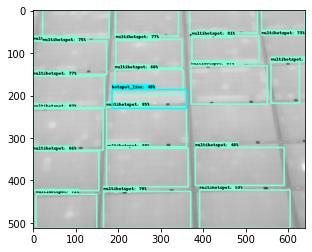

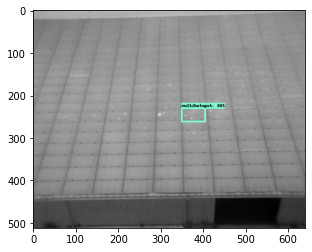

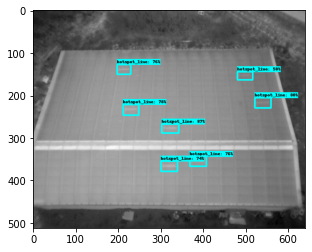

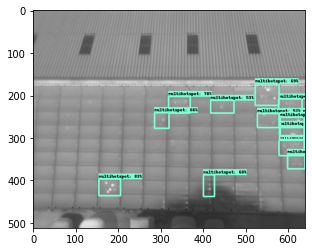

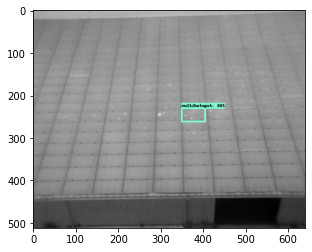

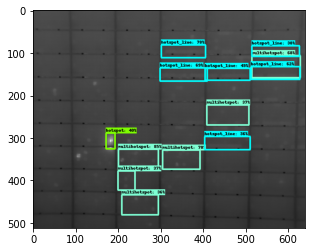

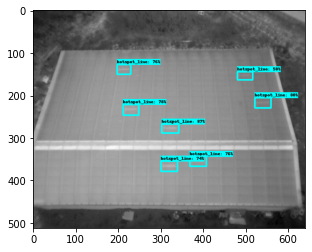

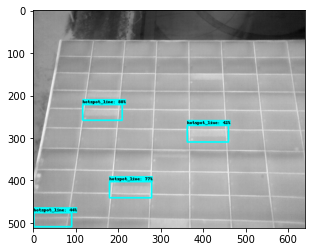

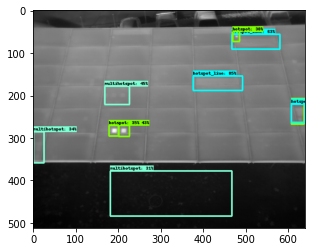

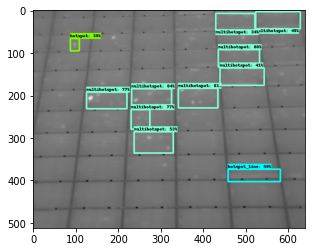

In [ ]:
# Inspiré de https://tensorflow-object-detection-api-tutorial.readthedocs.io/en/latest/auto_examples/plot_object_detection_saved_model.html#sphx-glr-auto-examples-plot-object-detection-saved-model-py
%matplotlib inline

test_df = pd.read_csv("./data/class_labels_multi_test.csv")
test_files = test_df['filename'].to_list()
IMAGES = [f"./data/Labeled/{f}" for f in test_files]
LABELS = 'data/label_map.pbtxt'
CHECKPOINT = f"./trained_models/{model_selected}"
CONFIG = f"./pre-trained-models/{model_selected}/{pipeline_file_name}"

# On charge le fichier de configuration du pipeline et on construit le modèle
configs = config_util.get_configs_from_pipeline_file(CONFIG)
model = model_builder.build(model_config=configs['model'], is_training=False)

# On restore le checkpoint
# UTILISER LE CHECKPOINT 2 POUR MOBILENET V1 ET LE 6 POUR RESNET50
tf.train.Checkpoint(model=model).restore(CHECKPOINT+'/ckpt-2').expect_partial()

@tf.function
def detect_fn(image):
    """Detect objects in image."""
    image, shapes = model.preprocess(image)
    prediction_dict = model.predict(image, shapes)
    detections = model.postprocess(prediction_dict, shapes)

    return detections

# On charge les données de la label map
classes = label_map_util.create_category_index_from_labelmap(LABELS, use_display_name=True)
for image_path in IMAGES[:10]:
    image_np = np.array(Image.open(image_path))
    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
    detections = detect_fn(input_tensor)

    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                  for key, value in detections.items()}
    detections['num_detections'] = num_detections
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)
    image = image_np.copy()
    result = visualization_utils.visualize_boxes_and_labels_on_image_array(
            image,
            detections['detection_boxes'],
            detections['detection_classes']+1,
            detections['detection_scores'],
            classes,
            use_normalized_coordinates=True,
            min_score_thresh=.30)
    plt.figure()
    plt.imshow(result)
    
    # Les résultats sont sauvegardés dans le dossier data/Tests
    tf.keras.preprocessing.image.save_img(f"./data/Tests/{image_path.split('/')[3]}", result)
plt.show()